# **NEO- Near-Earth Objects - Classification**
<br></br>
A near-Earth object (NEO) is any small Solar System body whose orbit brings it into proximity with Earth. By convention, a Solar System body is a NEO if its closest approach to the Sun (perihelion) is less than 1.3 astronomical units (AU).
<br></br>
## **PHAs**

A potentially hazardous asteroid (PHA) is a near-Earth object – an asteroid – with an orbit that can make close approaches to the Earth and is large enough to cause significant regional damage in the event of impact. Asteroids larger than approximately 35 meters across can pose a threat to a town or city.[14] However the diameter of most small asteroids is not well determined, as it is usually only estimated based on their brightness and distance, rather than directly measured, e.g. from radar observations.
</br></br>


In [1]:
import pandas as pd
from datetime import timedelta, date
import configparser
import pickle

#libraries for api get requests
import requests
from urllib.request import urlretrieve
import json

# Importing our visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# import evaluation functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score

# scikitplot to directly plot our results
import graphviz
import scikitplot as skplt
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import category_scatter

#Connection to Google Bigquery

import time

In [2]:
# Setting Column widthsize to view all columns in pandas data frame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
config = configparser.ConfigParser()
config.read('dl.cfg')
apiKey = config['NASA']['apikey']


# **NEO FEED**
### Source *api.nasa.gov*
### Collecting data of Asteroids based on their closest approach date to Earth.

```start_date = date(2002, 10, 8)
end_date = date(2021, 11, 30)

data_list=[]

for n in range(0,int ((end_date - start_date).days),7):
    new_start = start_date + timedelta(n)
    new_end = new_start + timedelta(6)
    new_start_date=new_start.strftime("%Y-%m-%d")
    new_end_date = new_end.strftime("%Y-%m-%d")
    
    url = f"https://api.nasa.gov/neo/rest/v1/feed?start_date={new_start_date}&end_date={new_end_date}&api_key={apiKey}"
    response = requests.get(url).json()
    
    for i in response["near_earth_objects"]:
        for n in range(len(response["near_earth_objects"][i])):
            data_list.append(response["near_earth_objects"][i][n])
```    

### **A Sample of Output Values extracted from API and appended to LIST**
```{'absolute_magnitude_h': 19.88,
 'close_approach_data': [{'close_approach_date': '2021-11-10',
                          'close_approach_date_full': '2021-Nov-10 20:29',
                          'epoch_date_close_approach': 1636576140000,
                          'miss_distance': {'astronomical': '0.2306734775',
                                            'kilometers': '34508260.899492925',
                                            'lunar': '89.7319827475',
                                            'miles': '21442439.023835365'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '46525.6340756068',
                                                'kilometers_per_second': '12.9237872432',
                                                'miles_per_hour': '28909.219684368'}}],
 'estimated_diameter': {'feet': {'estimated_diameter_max': 2060.7486784504,
                                 'estimated_diameter_min': 921.5948259116},
                        'kilometers': {'estimated_diameter_max': 0.6281161771,
                                       'estimated_diameter_min': 0.2809020939},
                        'meters': {'estimated_diameter_max': 628.116177092,
                                   'estimated_diameter_min': 280.902093949},
                        'miles': {'estimated_diameter_max': 0.3902931771,
                                  'estimated_diameter_min': 0.174544415}},
 'id': '2068347',
 'is_potentially_hazardous_asteroid': True,
 'is_sentry_object': False,
 'links': {'self': 'http://www.neowsapp.com/rest/v1/neo/2068347?api_key=xxxxxxxxxxxx'},
 'name': '68347 (2001 KB67)',
 'nasa_jpl_url': 'http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2068347',
 'neo_reference_id': '2068347'}
 ```

###  Reading Data in Pandas Dataframe

In [4]:
# Loading the data collected locally and reading in pandas df

with open("rawdata.pickle", "rb") as f:
   raw = pickle.load(f)

df = pd.DataFrame(raw)

In [5]:
#Droping Null Values
df.dropna(inplace=True)

In [6]:
# Getting Data from nested dictionaries of certain columns

df['estimated_diameter_min_km'] = df['estimated_diameter'].apply(lambda x: x['kilometers']['estimated_diameter_min'])

df['estimated_diameter_max_km'] = df['estimated_diameter'].apply(lambda x: x['kilometers']['estimated_diameter_max'])

df['close_approach_date'] = df['close_approach_data'].apply(lambda x: x[0]['close_approach_date'])

df['miss_distance_au'] = df['close_approach_data'].apply(lambda x: x[0]['miss_distance']['astronomical'])

df['relative_velocity_kmps'] = df['close_approach_data'].apply(lambda x: x[0]['relative_velocity']['kilometers_per_second'])

df['orbiting_body'] = df['close_approach_data'].apply(lambda x: x[0]['orbiting_body'])

In [7]:
# Checking Data types of different columns
df.dtypes

links                                 object
id                                    object
neo_reference_id                      object
name                                  object
nasa_jpl_url                          object
absolute_magnitude_h                 float64
estimated_diameter                    object
is_potentially_hazardous_asteroid       bool
close_approach_data                   object
is_sentry_object                        bool
estimated_diameter_min_km            float64
estimated_diameter_max_km            float64
close_approach_date                   object
miss_distance_au                      object
relative_velocity_kmps                object
orbiting_body                         object
dtype: object

In [8]:
# Changing data type from string to numeric

df[[
    'id',
    'neo_reference_id',
    'miss_distance_au',
    'relative_velocity_kmps',
]] = df[[
    'id',
    'neo_reference_id',
    'miss_distance_au',
    'relative_velocity_kmps',
]].apply(pd.to_numeric)

In [9]:
# Dropping columns not needed for analysis
model_frame = df.drop(columns=([
    'links', 'neo_reference_id', 'nasa_jpl_url', 'estimated_diameter',
    'close_approach_data'
]))
model_frame.tail(5)

,id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,estimated_diameter_min_km,estimated_diameter_max_km,close_approach_date,miss_distance_au,relative_velocity_kmps,orbiting_body
80587,54225724,(2021 XD),25.210,False,False,0.024130,0.053956,2021-11-28,0.071978,6.548339,Earth
80588,54226110,(2021 XM),27.122,False,False,0.010004,0.022369,2021-11-28,0.003351,8.748354,Earth
80589,54226410,(2021 XK1),26.396,False,False,0.013975,0.031249,2021-11-28,0.025174,8.852189,Earth
80590,54226786,(2021 XX1),27.741,False,False,0.007522,0.016821,2021-11-28,0.018287,8.581292,Earth
80591,54226789,(2021 XZ1),23.563,False,False,0.051518,0.115197,2021-11-28,0.248633,14.557350,Earth


### Tableau Visualization

[Tableau Dashboard](https://public.tableau.com/app/profile/kashish.verma4281/viz/NearEarthAsteroidsAnalysis/AretheumberofNEOIncreasing)

In [10]:
# Creating model_frame to use for machine learning models later 
## month value is extracted from the close_appreoach date to be used for ML model

model_frame[['y','month','d']] = model_frame['close_approach_date'].str.split('-',expand=True)

# Converiting the data type to date for main data frame for analysis on Tableau
df[['close_approach_date']] = df[['close_approach_date']].apply(pd.to_datetime)

In [11]:
# Droping the columns columns with nested dictionaries as the required data has been extracted
df.drop(columns=['links','estimated_diameter','close_approach_data'],inplace=True)

In [12]:
# Droping the columns not neded for the analysis
## y, d are not significant in predicting whethere an asteroid is a PHA, is sentry object is false for all the classes hence dropping it

model_frame = model_frame.drop(columns=([
    'y', 'd', 'close_approach_date', 'id', 'name', 'is_sentry_object',
    'orbiting_body'
]))

# Converting month into a numeric field

model_frame['month'] = model_frame['month'].apply(pd.to_numeric)

In [13]:
# All our data is now in numeric form except the target variable.

model_frame.dtypes

absolute_magnitude_h                 float64
is_potentially_hazardous_asteroid       bool
estimated_diameter_min_km            float64
estimated_diameter_max_km            float64
miss_distance_au                     float64
relative_velocity_kmps               float64
month                                  int64
dtype: object

# **ML MODELS**
## Testing different ml models to predict a PHA.

In [14]:
model_frame['is_potentially_hazardous_asteroid'].value_counts()

False    72841
True      7750
Name: is_potentially_hazardous_asteroid, dtype: int64

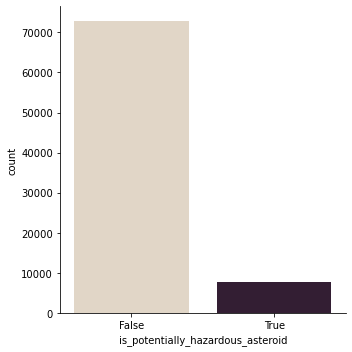

In [15]:
sns.catplot(x="is_potentially_hazardous_asteroid", kind="count", palette="ch:.25", data= model_frame)

# **Downsampling**

### The above numbers shows that we have a imbalanced dataset as there are a lot of False values for target variable - *is_potentially_hazardous_asteroid* , because of this, the accuracy score will be heavily impacted by the number of False values predicted by the Machine Learning Model.

### So In order to avoid that we will be randomly droping the rows with the false value for our target variable to attain approximately 50% balance between both the values

In [16]:
# Randomly deleting 89 % of data where is_potentially_hazardous_asteroid is False using code below:

model_frame = model_frame.drop(model_frame[model_frame['is_potentially_hazardous_asteroid'] == False].sample(frac=.89).index)

In [17]:
model_frame['is_potentially_hazardous_asteroid'].value_counts()

False    8013
True     7750
Name: is_potentially_hazardous_asteroid, dtype: int64

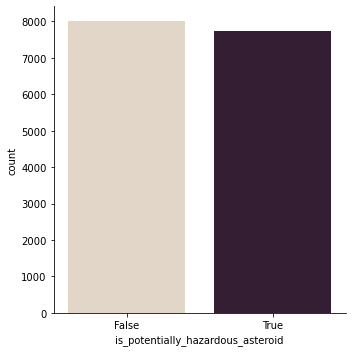

In [18]:
sns.catplot(x="is_potentially_hazardous_asteroid", kind="count", palette="ch:.25", data= model_frame)

### Above we can see that now we have balanced dataset which will be used to train ML models.
<br></br>
### Now lets look at distribution of data to make sure our data is not skewed after dropping the random rows

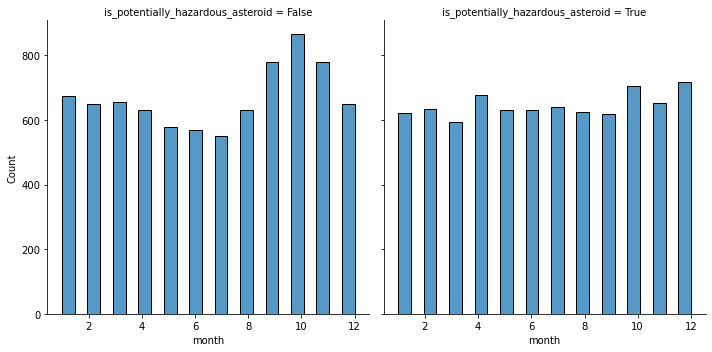

In [19]:
sns.displot(model_frame, x="month", col='is_potentially_hazardous_asteroid')

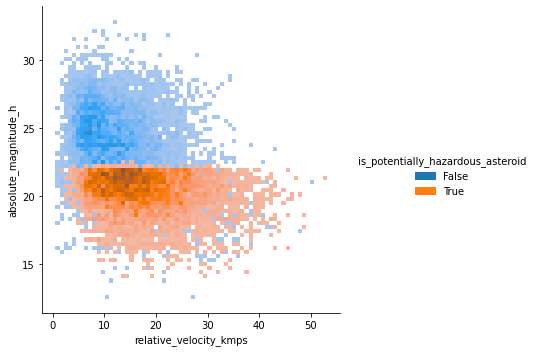

In [20]:
sns.displot(model_frame, x="relative_velocity_kmps", y="absolute_magnitude_h", hue="is_potentially_hazardous_asteroid")


#### Above graph shows a strong concentration of PHAs at relative velocity between 10 to 20 Kmps and an Absolute value H between 20 -22.5

# Correlation among different features.

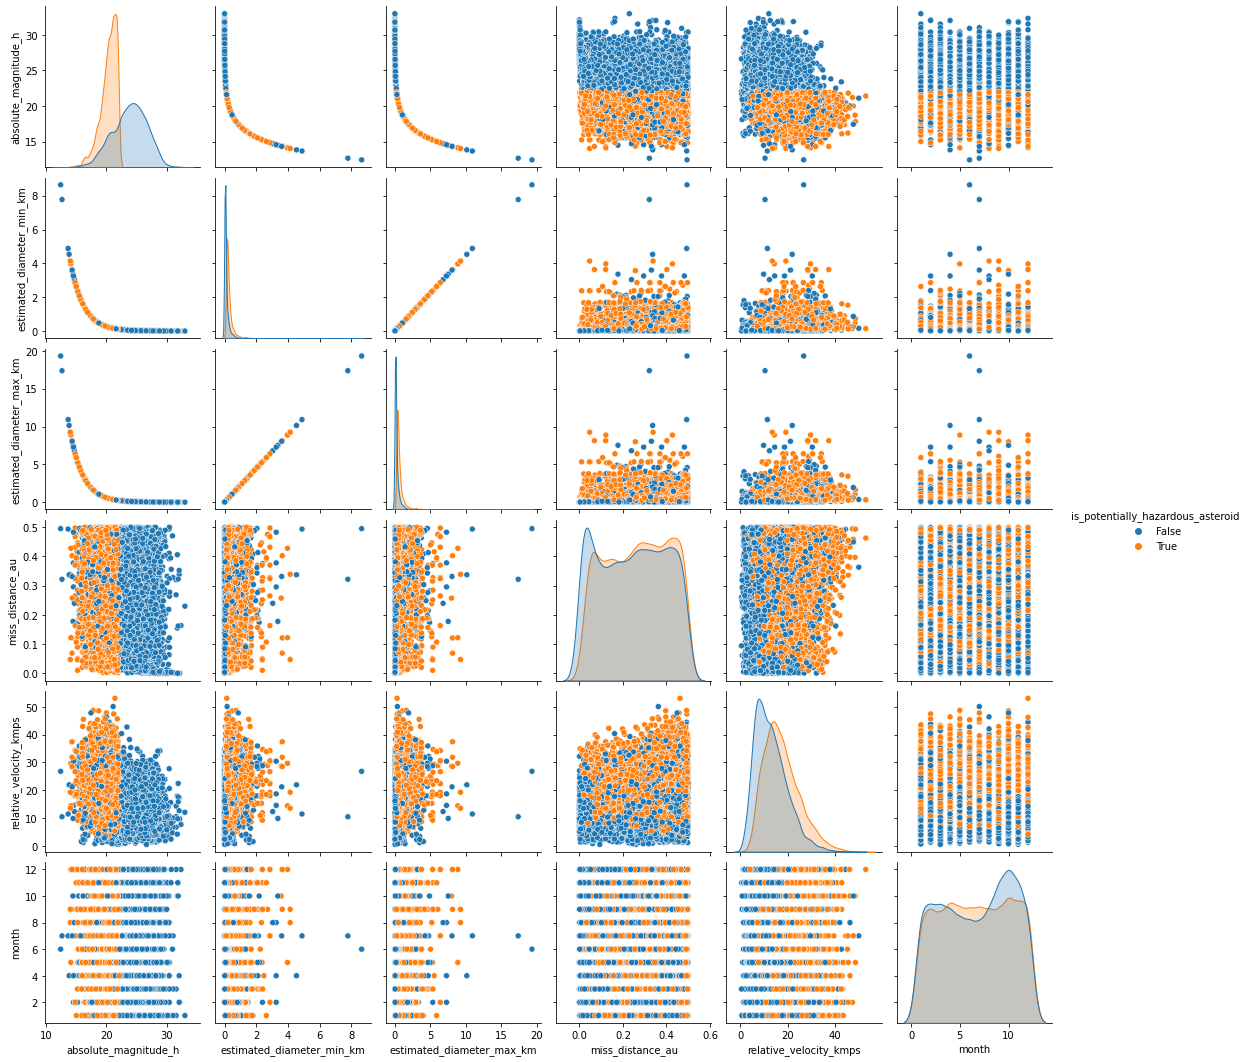

In [21]:
sns.pairplot(model_frame, hue="is_potentially_hazardous_asteroid")

Note: 
**Absolute Magnitude H**
<br></br>
An asteroid’s absolute magnitude is the visual magnitude (measure of luminosity/brightness) an observer would record if the asteroid were placed 1 Astronomical Unit (au) away from the observer, and 1 au from the Sun and at a zero phase angle.
<br></br>

<AxesSubplot:>

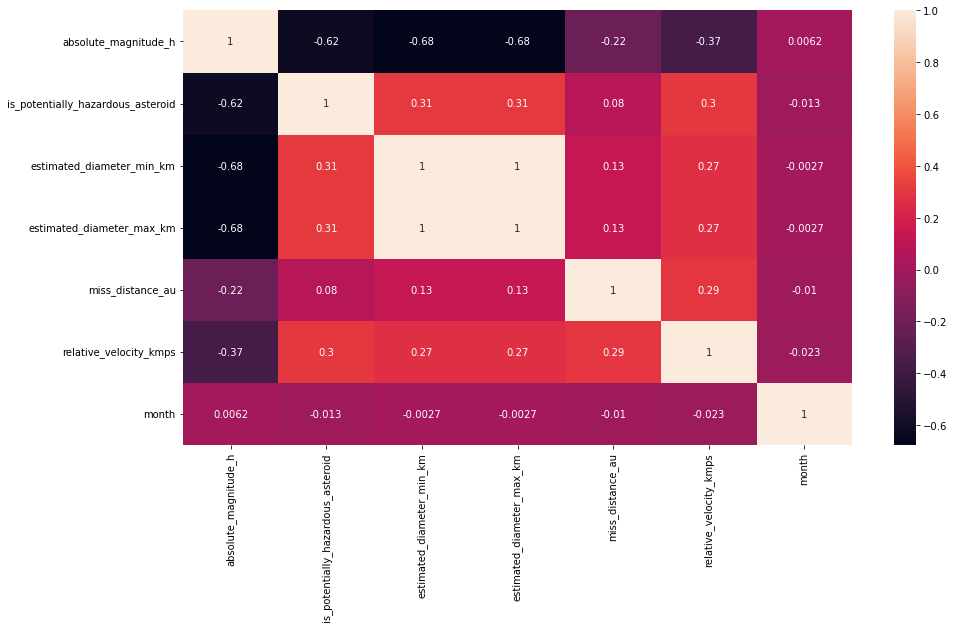

In [22]:
# correlation analysis
correlationanalysis = model_frame.corr()

# Resizing trick from matplotlib
plt.figure(figsize=(15,8))

# setting the annot argument to "True" to display labels
sns.heatmap(correlationanalysis,annot=True)

In [23]:
# Looking at some stats on the data
model_frame.describe()

,absolute_magnitude_h,estimated_diameter_min_km,estimated_diameter_max_km,miss_distance_au,relative_velocity_kmps,month
count,15763.000000,15763.000000,15763.000000,15763.000000,15763.000000,15763.000000
mean,22.067442,0.204295,0.456817,0.254435,15.177909,6.656982
std,2.819302,0.295637,0.661064,0.146104,7.516906,3.496806
min,12.440000,0.000683,0.001528,0.000045,0.486905,1.000000
25%,20.200000,0.042126,0.094198,0.126626,9.471807,4.000000
50%,21.500000,0.133216,0.297879,0.260819,14.096847,7.000000
75%,24.000000,0.242412,0.542051,0.381788,19.560308,10.000000
max,32.950000,8.640820,19.321462,0.499947,53.104572,12.000000


# Training ML model and comparing accuracy results

In [24]:
## Independent Variable
# including all previous columns, only dropping the dependent variable 'is_potentially_hazardous_asteroid'

X = model_frame[[
    'absolute_magnitude_h', 'estimated_diameter_min_km',
    'estimated_diameter_max_km', 'miss_distance_au', 'relative_velocity_kmps',
    'month'
]]

## Target variable
# ensuring our y (prediction) is only included
y = model_frame['is_potentially_hazardous_asteroid']

In [25]:
#Creating Test and validation set

X_train, X2, y_train, y2 = train_test_split(X, y, test_size=0.2, random_state=30)

X_val, X_test, y_val, y_test = train_test_split(X2, y2, test_size=0.5, random_state=30)

# **Logistic Regression Model**

In [31]:
# initializing our logistic regression model, we set the maximum iterations to 3000 so that the model can find a solution. The default may be sufficient in most cases (100)
lr = LogisticRegression(random_state=7007, max_iter=3000)
lr.fit(X_train, y_train)

# using our model to predict
y_pred = lr.predict(X_test)

# evaluation
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Accuracy Score: 0.8427393785668992


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.77      0.84       822
        True       0.79      0.92      0.85       755

    accuracy                           0.84      1577
   macro avg       0.85      0.85      0.84      1577
weighted avg       0.85      0.84      0.84      1577



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

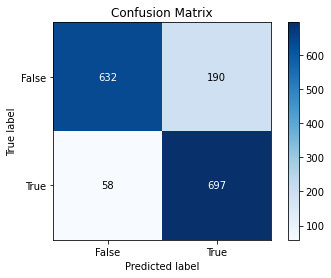

In [33]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

In [34]:
#Validation Set testing
lr = LogisticRegression(random_state=7007, max_iter=3000)
lr.fit(X_train, y_train)

# using our model to predict
y_pred = lr.predict(X_val)

# evaluation
print("Logistic Regression Accuracy Score on validation set:",accuracy_score(y_val, y_pred))

Logistic Regression Accuracy Score on validation set: 0.8489847715736041


# **Decesion Tree**

In [35]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy Score:",accuracy_score(y_test, y_pred))


Accuracy Score: 0.8129359543436906


## **SVM Model**

In [36]:
svm = SVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print("Accuracy Score : ", accuracy_score(y_test,y_pred))

Accuracy Score :  0.8446417247939125


In [37]:
#Validation
svm = SVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_val)
print("Accuracy Score : ", accuracy_score(y_val,y_pred))

Accuracy Score :  0.8407360406091371


# **Model 4: kNN**

In [38]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy Score : ", accuracy_score(y_test,y_pred))

Accuracy Score :  0.8230818008877616


# **Model 5: random forest**

### Hyperparameter Tuning for number of trees

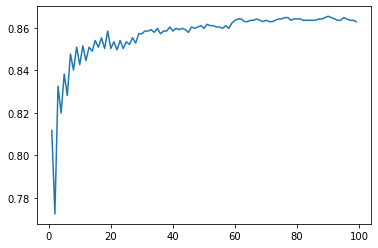

In [39]:
# the range of trees we want to test
numberoftrees = range(1, 100)
scores = []

# for loop
for n in numberoftrees:
    # in the n_estimators parameter, we're going to be testing all the values found in our range
    rf = RandomForestClassifier(n_estimators=n, random_state=1337)
    # fitting our model
    rf.fit(X_train, y_train)
    #prediction
    y_pred = rf.predict(X_test)
    # appending our result to variable scores
    scores.append(accuracy_score(y_test, y_pred))

# plotting our results
plt.plot(numberoftrees, scores)

## Hyperparameter tuning for max_depth

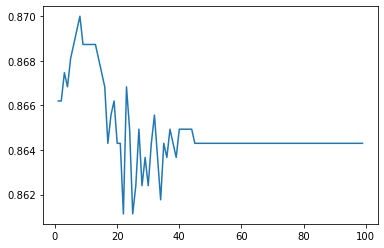

In [40]:
# the range of trees we want to test
depth = range(1, 100)
scores = []

# for loop
for n in depth:
    # in the n_estimators parameter, we're going to be testing all the values found in our range
    rf = RandomForestClassifier(n_estimators=67, max_depth= n, random_state=1337)
    # fitting our model
    rf.fit(X_train, y_train)
    #prediction
    y_pred = rf.predict(X_test)
    # appending our result to variable scores
    scores.append(accuracy_score(y_test, y_pred))

# plotting our results
plt.plot(numberoftrees, scores)

In [26]:
# initializing our random forest model
rf = RandomForestClassifier(n_estimators=67, max_depth = 18)
rf.fit(X_train, y_train)

# using our model to predict
y_pred = rf.predict(X_test)

# accuracy score
print("The accuracy score of Random Forest Model :",accuracy_score(y_test, y_pred))

The accuracy score of Random Forest Model : 0.8579581483830057


In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.74      0.85       826
        True       0.78      0.99      0.87       751

    accuracy                           0.86      1577
   macro avg       0.88      0.86      0.86      1577
weighted avg       0.88      0.86      0.86      1577



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

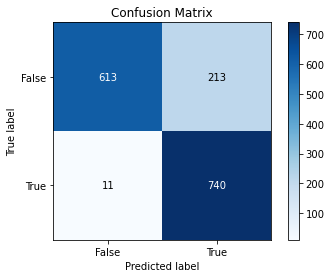

In [28]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

In [29]:
# Testing on Validation Set

rf = RandomForestClassifier(n_estimators=67,max_depth = 18, random_state=110)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print("RF MODEL - Validation Set accuracy : ",accuracy_score(y_val, y_pred))

RF MODEL - Validation Set accuracy :  0.873730964467005


In [30]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.77      0.86       810
        True       0.80      0.99      0.88       766

    accuracy                           0.87      1576
   macro avg       0.89      0.88      0.87      1576
weighted avg       0.90      0.87      0.87      1576



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

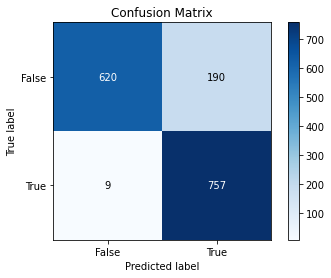

In [31]:
skplt.metrics.plot_confusion_matrix(y_val, y_pred)

<AxesSubplot:title={'center':'Feature Importance'}>

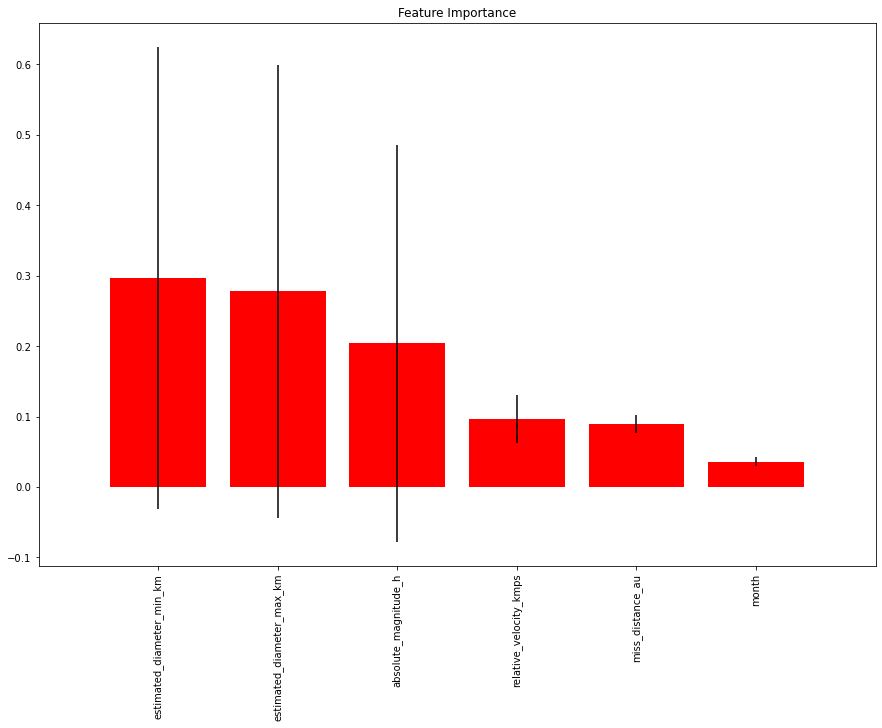

In [32]:
# assigning column names to variable 'feature_names'
feature_names = X.columns

skplt.estimators.plot_feature_importances(rf, feature_names=feature_names, figsize=(15, 10), x_tick_rotation=90)

# Testing Models after removing multicollinearity

In [48]:
## Removing estimated_diameter_max_km as it has collinerity with estimated_diameter_min_km

X0 = model_frame[[
    'absolute_magnitude_h', 'estimated_diameter_min_km',
    'miss_distance_au', 'relative_velocity_kmps',
    'month'
]]

## Target variable
# ensuring our y (prediction) is only included
y0 = model_frame['is_potentially_hazardous_asteroid']

In [49]:
#Creating validation set

X0_train, X1, y0_train, y1 = train_test_split(X0, y0, test_size=0.2, random_state=30)

X0_val, X0_test, y0_val, y0_test = train_test_split(X1, y1, test_size=0.5, random_state=30)

# Logistic Regression

In [50]:
# initializing our logistic regression model, we set the maximum iterations to 3000 so that the model can find a solution. The default may be sufficient in most cases (100)
lr = LogisticRegression(random_state=7007, max_iter=3000)
lr.fit(X0_train, y0_train)

# using our model to predict
y0_pred = lr.predict(X0_test)

# evaluation
print("Accuracy Score:", accuracy_score(y0_test, y0_pred))

Accuracy Score: 0.8427393785668992


In [51]:
print(classification_report(y0_test, y0_pred))

              precision    recall  f1-score   support

       False       0.92      0.77      0.84       822
        True       0.79      0.92      0.85       755

    accuracy                           0.84      1577
   macro avg       0.85      0.85      0.84      1577
weighted avg       0.85      0.84      0.84      1577



# **Decesion Tree**

In [52]:
dt0 = DecisionTreeClassifier()
dt0.fit(X0_train, y0_train)
y0_pred = dt0.predict(X0_test)
print("Decesion Treed Accuracy Score:",accuracy_score(y0_test, y0_pred))


Decesion Treed Accuracy Score: 0.8097653772986684


## **SVM Model**

In [53]:
svm0 = SVC()
svm0.fit(X0_train, y0_train)

y0_pred = svm0.predict(X0_test)
print("svm Accuracy Score : ", accuracy_score(y0_test,y0_pred))

svm Accuracy Score :  0.8414711477488903


# **kNN** Model

In [54]:
knn0 = KNeighborsClassifier(n_neighbors=3)
knn0.fit(X0_train, y0_train)
y0_pred = knn0.predict(X0_test)
print("kNN Accuracy Score : ", accuracy_score(y0_test,y0_pred))

kNN Accuracy Score :  0.8199112238427394


#  Random Forest

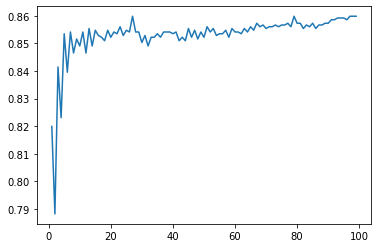

In [55]:
# the range of trees we want to test
numberoftrees = range(1, 100)
scores = []

# for loop
for n in numberoftrees:
    # in the n_estimators parameter, we're going to be testing all the values found in our range
    rf = RandomForestClassifier(n_estimators=n, random_state=1337)
    # fitting our model
    rf.fit(X0_train, y0_train)
    #prediction
    y0_pred = rf.predict(X0_test)
    # appending our result to variable scores
    scores.append(accuracy_score(y0_test, y0_pred))

# plotting our results
plt.plot(numberoftrees, scores)

In [56]:
rf0 = RandomForestClassifier(n_estimators=90)
rf0.fit(X0_train, y0_train)

# using our model to predict
y0_pred = rf0.predict(X0_test)

# accuracy score
print("Random Forest Accuracy: ",(accuracy_score(y0_test, y0_pred)))

Random Forest Accuracy:  0.8617628408370324


In [57]:
# Testing on Validation Set

rf0 = RandomForestClassifier(n_estimators=90, random_state=110)
rf0.fit(X0_train, y0_train)
y0_pred = rf0.predict(X0_val)
print("RF MODEL - Validation Set accuracy : ",accuracy_score(y0_val, y0_pred))

RF MODEL - Validation Set accuracy :  0.858502538071066


# We can ignore multicollinearty among the estimated_ diameter_max and min variables as we dont see any impact on prediction accuracy on any of the model .

<br></br>
# Testing on Latest Data released by NASA. (2021/12/1 - 2021/12/08)

```# Collecting new data from api

start_date2 = date(2021, 12, 1)
end_date2 = date(2021, 12, 9)

data_list2=[]

for n in range(0,int ((end_date2 - start_date2).days),7):
    new_start2 = start_date2 + timedelta(n)
    new_end2 = new_start2 + timedelta(6)
    new_start_date2=new_start2.strftime("%Y-%m-%d")
    new_end_date2 = new_end2.strftime("%Y-%m-%d")
    
    url2 = f"https://api.nasa.gov/neo/rest/v1/feed?start_date={new_start_date2}&end_date={new_end_date2}&api_key={apiKey}"
    response2 = requests.get(url2).json()
    
    for i in response2["near_earth_objects"]:
        for n in range(len(response2["near_earth_objects"][i])):
            data_list2.append(response2["near_earth_objects"][i][n])
```

```
#Saving the data locally as a text file to be reused

with open("latestrawdata.pickle", "wb") as f:
   pickle.dump(data_list2, f)
```

In [33]:
# Loading the data collected locally and reading in pandas df

with open("latestrawdata.pickle", "rb") as f:
   raw_new = pickle.load(f)

df_new = pd.DataFrame(raw_new)

In [34]:
# Getting Data from nested dictionaries of certain columns

df_new['estimated_diameter_min_km'] = df_new['estimated_diameter'].apply(lambda x: x['kilometers']['estimated_diameter_min'])

df_new['estimated_diameter_max_km'] = df_new['estimated_diameter'].apply(lambda x: x['kilometers']['estimated_diameter_max'])

df_new['close_approach_date'] = df_new['close_approach_data'].apply(lambda x: x[0]['close_approach_date'])

df_new['miss_distance_au'] = df_new['close_approach_data'].apply(lambda x: x[0]['miss_distance']['astronomical'])

df_new['relative_velocity_kmps'] = df_new['close_approach_data'].apply(lambda x: x[0]['relative_velocity']['kilometers_per_second'])

df_new['orbiting_body'] = df_new['close_approach_data'].apply(lambda x: x[0]['orbiting_body'])

In [35]:
# Changing data type from string to numeric

df_new[[
    'id',
    'neo_reference_id',
    'miss_distance_au',
    'relative_velocity_kmps',
]] = df_new[[
    'id',
    'neo_reference_id',
    'miss_distance_au',
    'relative_velocity_kmps',
]].apply(pd.to_numeric)

In [36]:
# Dropping columns not needed for analysis
new_data = df_new.drop(columns=([
    'links', 'neo_reference_id', 'nasa_jpl_url', 'estimated_diameter',
    'close_approach_data'
]))
new_data.tail(5)

,id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,estimated_diameter_min_km,estimated_diameter_max_km,close_approach_date,miss_distance_au,relative_velocity_kmps,orbiting_body
220,54017179,(2020 KZ2),27.700,False,False,0.007666,0.017141,2021-12-08,0.127443,5.627040,Earth
221,54137509,(2021 GS12),25.600,False,False,0.020163,0.045086,2021-12-08,0.265263,8.855889,Earth
222,54225512,(2021 WT4),26.718,False,False,0.012049,0.026943,2021-12-08,0.027733,6.417811,Earth
223,54225722,(2021 XC),26.286,False,False,0.014701,0.032873,2021-12-08,0.016642,6.858105,Earth
224,54226788,(2021 XY1),24.925,False,False,0.027514,0.061523,2021-12-08,0.112600,9.882717,Earth


In [37]:
# Creating model_frame to use for machine learning models later 
## month value is extracted from the close_appreoach date to be used for ML model

new_data[['y','month','d']] = new_data['close_approach_date'].str.split('-',expand=True)


In [38]:
# Droping the columns not neded for the analysis
## y, d are not significant in predicting whethere an asteroid is a PHA, is sentry object is false for all the classes hence dropping it

new_data = new_data.drop(columns=([
    'y', 'd', 'close_approach_date', 'id', 'name', 'is_sentry_object',
    'orbiting_body'
]))

# Converting month into a numeric field

new_data['month'] = new_data['month'].apply(pd.to_numeric)

In [39]:
# All our data is now in numeric form except the target variable.

new_data['is_potentially_hazardous_asteroid'].value_counts()

False    208
True      17
Name: is_potentially_hazardous_asteroid, dtype: int64

### **New Dataset has 17 PHAs**

In [40]:
X_new = new_data[[
    'absolute_magnitude_h', 'estimated_diameter_min_km',
    'estimated_diameter_max_km','miss_distance_au', 'relative_velocity_kmps',
    'month'
]]

## Target variable
y_new = new_data['is_potentially_hazardous_asteroid']

In [41]:
# Testing on Validation Set

rf = RandomForestClassifier(n_estimators=67,max_depth = 18, random_state=110)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_new)
print("RF MODEL - Latest Data Set accuracy : ",accuracy_score(y_new, y_pred))

RF MODEL - Latest Data Set accuracy :  0.8444444444444444


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

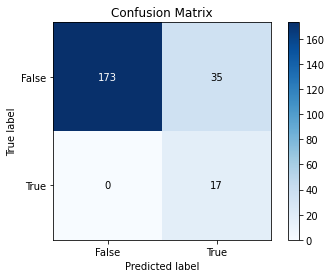

In [42]:
skplt.metrics.plot_confusion_matrix(y_new, y_pred)

In [43]:
print(classification_report(y_new, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.83      0.91       208
        True       0.33      1.00      0.49        17

    accuracy                           0.84       225
   macro avg       0.66      0.92      0.70       225
weighted avg       0.95      0.84      0.88       225



# Conclusion

The random forest ML model predicted all the PHAs on the new data recently released by NASA, with 1.0 recall for True Values. We get good results and no Type 1 errors. The model can further be used to train on newer data to improve and classify PHAs, helping us to detect potential threats from newer asteroids.

# Data Ethics

## How data is used?
The data is collected ethically from NASA open api and is available in public domain, and contains no private information. The data is collected only to gain understanding if a machine learning algorithm can be trained to predict potential hazardous asteroids. Steps have been taken to make sure the results produced by data analysis are not intentionally biased.

## How someone else might use it?
No Ethical concerns with a potential misuse of data as it doesn't contain any personal data of any person.